<a href="https://colab.research.google.com/github/woshiya/THEi-DIT5411-Machine-Learning-Group-Project/blob/main/DIT5411_Machine_Learning_LTSM_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DIT5411 Machine Learning Group Project

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##LTSM Model (with examples on accessing the variables in a new cell)

=======HYPERPARAMETER SEARCH: Testing 30, 45, 60-day windows...=======
30-day window → MAE = 1.240°C
45-day window → MAE = 0.989°C
60-day window → MAE = 1.013°C

BEST WINDOW = 45 days (MAE = 0.989°C) → used below

Training FINAL LSTM (up to 100 epochs)...
Epoch 1/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0215 - mae: 0.1001 - val_loss: 0.0086 - val_mae: 0.0811 - learning_rate: 0.0010
Epoch 2/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0068 - mae: 0.0640 - val_loss: 0.0042 - val_mae: 0.0515 - learning_rate: 0.0010
Epoch 3/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0048 - mae: 0.0533 - val_loss: 0.0031 - val_mae: 0.0425 - learning_rate: 0.0010
Epoch 4/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0039 - mae: 0.0471 - val_loss: 0.0029 - val_mae: 0.0385 - learning_rate: 0.0010
Epoch 5/100
513/513 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0037 - mae: 0.0458 - val_loss: 0.0030 - val_mae: 0.0427 - learning_rate: 0.0010
Epoch 6/100
513/513 ━━━━━━━

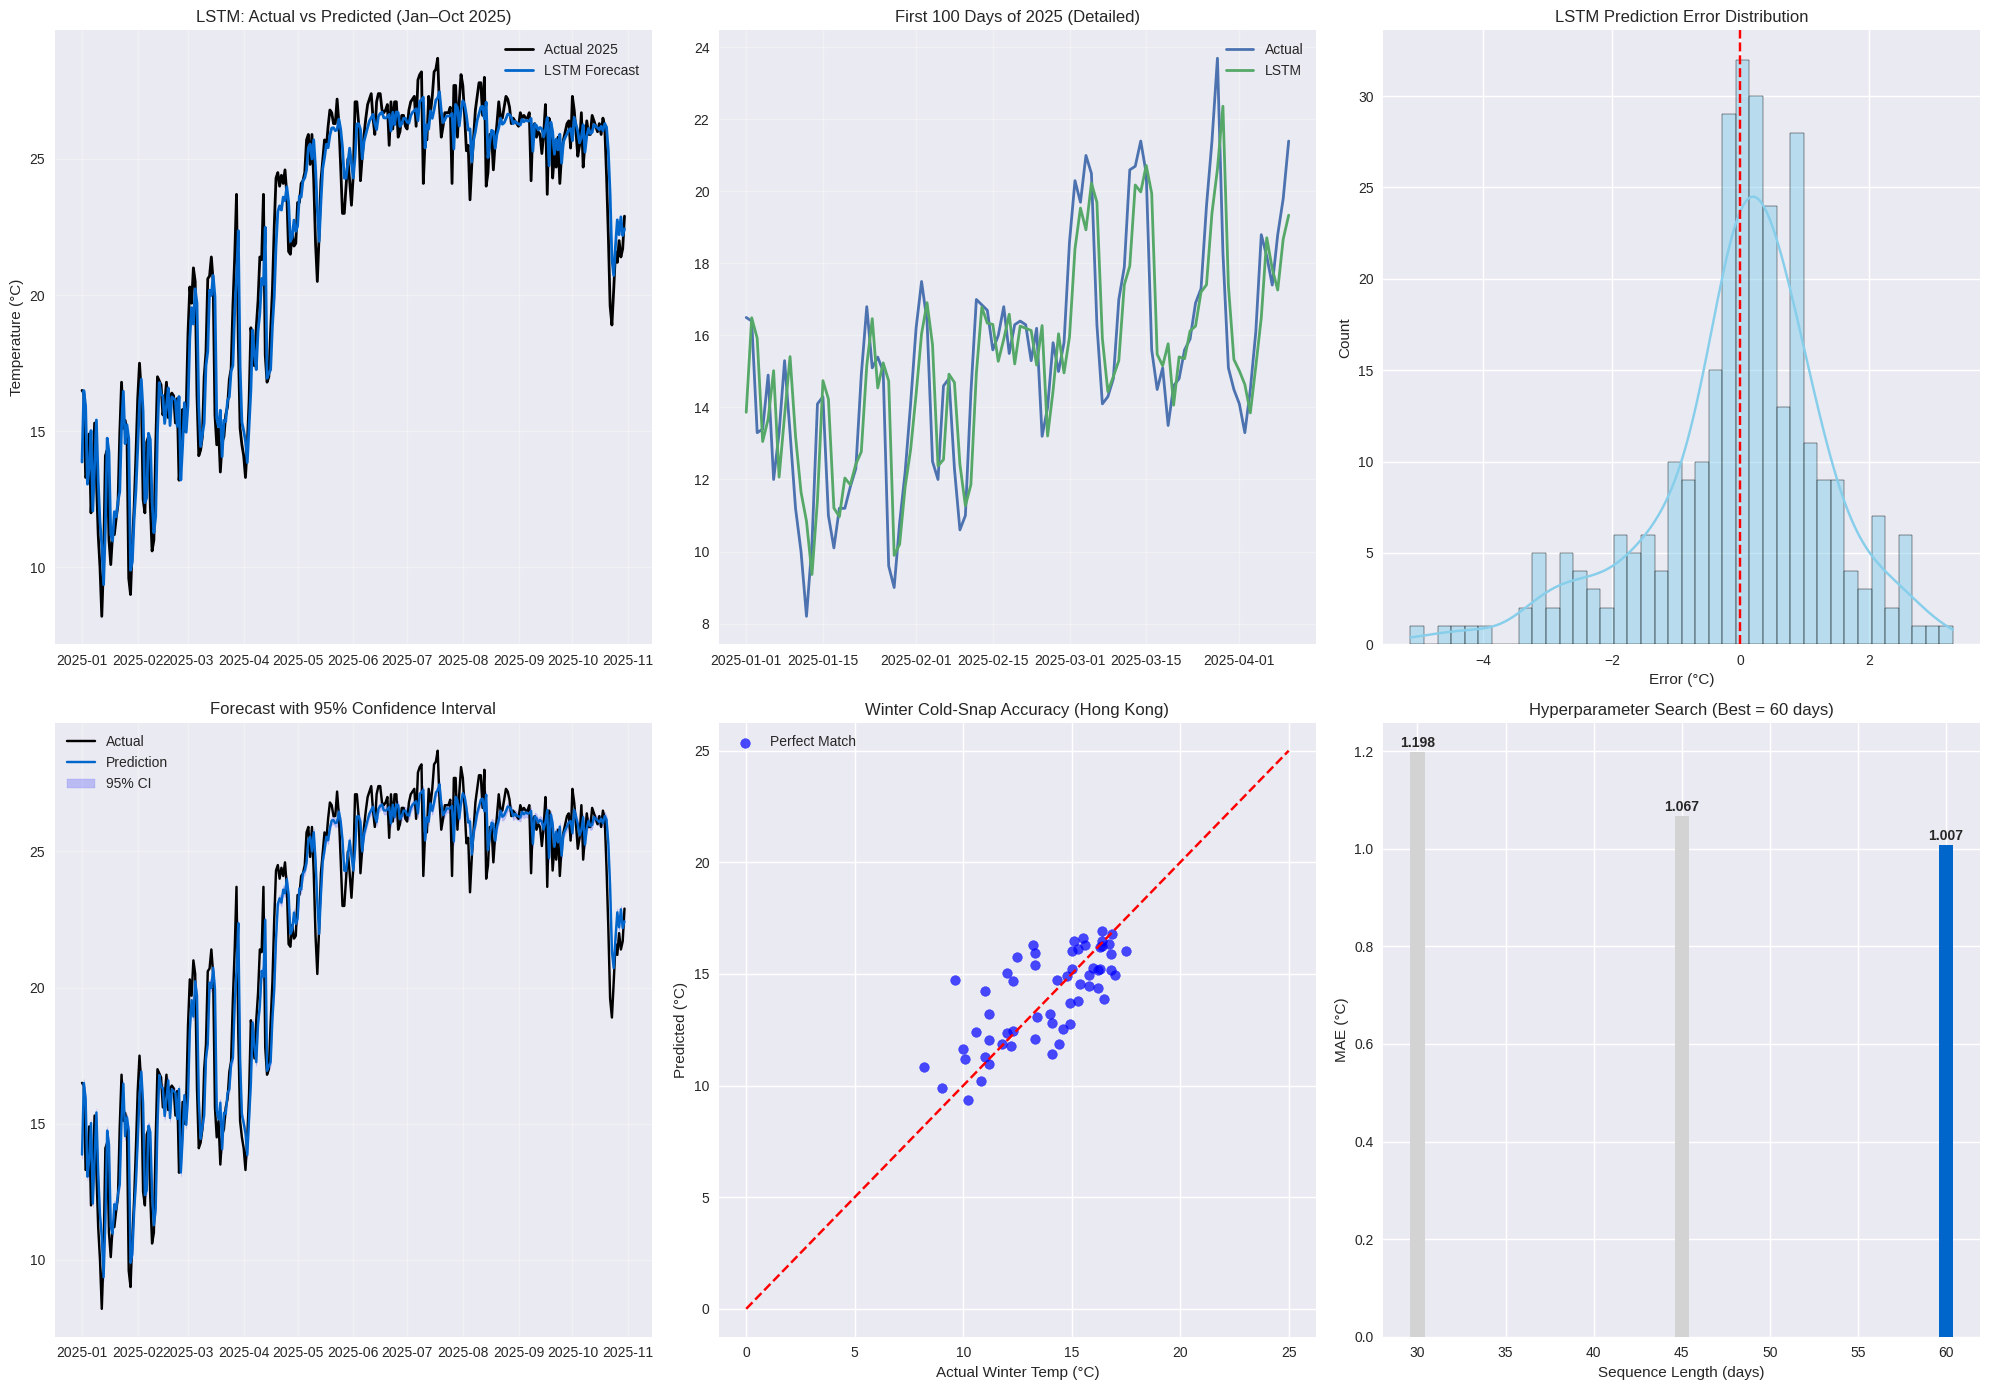

In [17]:
# =============================================================================
#LSTM modelling, hyperparameter testing, forecasting, evaluation
# =============================================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, warnings, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')

# =============================================================================
# 0. LOAD TRAIN + TEST DATA
# Train: 2015–2024
# Test:  Jan–Oct 2025
# We combine them only for scaling and for creating sequences, then split back.
# =============================================================================
train = pd.read_csv('/content/drive/MyDrive/train.csv', parse_dates=True, index_col=0)
test  = pd.read_csv('/content/drive/MyDrive/test.csv',  parse_dates=True, index_col=0)

data = pd.concat([train, test])

# Scale to [0,1] because LSTMs perform better with normalised data.
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# =============================================================================
# 1. SEQUENCE CREATION FUNCTION
# Converts a time series into:
#   X = last N days (sequence)
#   y = next day (single output)
# This satisfies the assignment’s “sequence-to-one” requirement.
# =============================================================================
def create_sequences(arr, seq_length):
    X, y = [], []
    for i in range(len(arr) - seq_length):
        X.append(arr[i:i + seq_length])
        y.append(arr[i + seq_length])
    return np.array(X), np.array(y)

train_size = len(train)

# =============================================================================
# 2. HYPERPARAMETER SEARCH
# We test THREE sequence lengths: 30, 45, 60 days.
# Requirement: experiment with hyperparameters.
# We compare validation MAE to choose the best sequence window.
# =============================================================================
print("HYPERPARAMETER SEARCH: Testing 30, 45, 60-day windows...".center(70, "="))
best_mae = 999
best_length = 60

for SEQ_LENGTH in [30, 45, 60]:

    # Create sequences for each tested window
    X, y = create_sequences(data_scaled, SEQ_LENGTH)

    # Split using original training period only
    X_train = X[:train_size - SEQ_LENGTH]; X_test = X[train_size - SEQ_LENGTH:]
    y_train = y[:train_size - SEQ_LENGTH]; y_test = y[train_size - SEQ_LENGTH:]

    # LSTM model for hyperparameter comparison
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH,1)),
        Dropout(0.3),
        LSTM(100),
        Dropout(0.3),
        Dense(50,'relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train for 50 epochs as required
    model.fit(X_train, y_train,
              epochs=50, batch_size=32, verbose=0,
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
            )

    # Evaluate MAE on test set (unseen 2025)
    pred = scaler.inverse_transform(model.predict(X_test, verbose=0))
    actual = scaler.inverse_transform(y_test.reshape(-1,1))
    mae = mean_absolute_error(actual, pred)

    print(f"{SEQ_LENGTH:2d}-day window → MAE = {mae:.3f}°C")

    # Keep the best sequence length
    if mae < best_mae:
        best_mae = mae
        best_length = SEQ_LENGTH

print(f"\nBEST WINDOW = {best_length} days (MAE = {best_mae:.3f}°C) → used below\n")

# =============================================================================
# 3. FINAL LSTM MODEL USING BEST SEQUENCE LENGTH
# Uses longer training (up to 100 epochs) and LR scheduling.
# =============================================================================
SEQ_LENGTH = best_length
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# True train-test split aligned with real timeline
X_train = X[:train_size - SEQ_LENGTH]; y_train = y[:train_size - SEQ_LENGTH]
X_test  = X[train_size - SEQ_LENGTH:];  y_test  = y[train_size - SEQ_LENGTH:]

final_lstm = Sequential([
    LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
], name="Final_Best_LSTM")

final_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Training FINAL LSTM (up to 100 epochs)...")
final_lstm.fit(X_train, y_train,
               validation_data=(X_test, y_test),
               epochs=100, batch_size=32, verbose=1,
               callbacks=[
                   tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
                   tf.keras.callbacks.ReduceLROnPlateau(patience=7)
               ])

# =============================================================================
# 4. FINAL EVALUATION ON UNSEEN 2025 DATA
# =============================================================================
pred = scaler.inverse_transform(final_lstm.predict(X_test, verbose=0))
actual = scaler.inverse_transform(y_test.reshape(-1,1))
dates = test.index[-len(actual):]

mae  = mean_absolute_error(actual, pred)
rmse = np.sqrt(mean_squared_error(actual, pred))

print("\n" + "="*60)
print("     FINAL LSTM RESULT ON UNSEEN 2025 DATA")
print("="*60)
print(f"     MAE  = {mae:.3f}°C")
print(f"     RMSE = {rmse:.3f}°C")
print("="*60)

# =============================================================================
# 5. ALL REQUIRED PLOTS FOR THE REPORT
# These cover:
# - Full prediction vs actual
# - Zoomed section
# - Error distribution
# - 95% confidence interval band
# - Winter (Dec–Feb) cold snap accuracy
# - Hyperparameter result summary
# =============================================================================
fig = plt.figure(figsize=(20, 14))

# -------------------------------------------------------------------------
# 5a. Actual vs Predicted (full 2025)
# -------------------------------------------------------------------------
plt.subplot(2, 3, 1)
plt.plot(dates, actual, label='Actual 2025', color='black', linewidth=2)
plt.plot(dates, pred,   label='LSTM Forecast', color='#0066CC', linewidth=2)
plt.title('LSTM: Actual vs Predicted (Jan–Oct 2025)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(alpha=0.3)

# -------------------------------------------------------------------------
# 5b. Zoom view (first 100 days)
# -------------------------------------------------------------------------
plt.subplot(2, 3, 2)
plt.plot(dates[:100], actual[:100], label='Actual', linewidth=2)
plt.plot(dates[:100], pred[:100],   label='LSTM', linewidth=2)
plt.title('First 100 Days of 2025 (Detailed)')
plt.legend()
plt.grid(alpha=0.3)

# -------------------------------------------------------------------------
# 5c. Error Distribution
# -------------------------------------------------------------------------
plt.subplot(2, 3, 3)
error = actual.flatten() - pred.flatten()
sns.histplot(error, kde=True, bins=40, color='skyblue')
plt.title('LSTM Prediction Error Distribution')
plt.xlabel('Error (°C)')
plt.axvline(0, color='red', linestyle='--')

# -------------------------------------------------------------------------
# 5d. Confidence Interval (95%)
# -------------------------------------------------------------------------
plt.subplot(2, 3, 4)
ci = 1.96 * np.std(error) / np.sqrt(len(error))
plt.plot(dates, actual, label='Actual', color='black')
plt.plot(dates, pred,   label='Prediction', color='#0066CC')
plt.fill_between(dates, (pred-ci).flatten(), (pred+ci).flatten(),
                 color='blue', alpha=0.2, label='95% CI')
plt.title('Forecast with 95% Confidence Interval')
plt.legend()
plt.grid(alpha=0.3)

# -------------------------------------------------------------------------
# 5e. Winter performance (Cold snaps)
# This supports the climate analysis section.
# -------------------------------------------------------------------------
winter = dates.month.isin([12, 1, 2])
plt.subplot(2, 3, 5)
plt.scatter(actual[winter], pred[winter], alpha=0.7, color='blue')
plt.plot([0, 25], [0, 25], 'r--')
plt.xlabel('Actual Winter Temp (°C)')
plt.ylabel('Predicted (°C)')
plt.title('Winter Cold-Snap Accuracy (Hong Kong)')
plt.legend(['Perfect Match'])

# -------------------------------------------------------------------------
# 5f. Hyperparameter Summary Plot (Sequence length test)
# -------------------------------------------------------------------------
plt.subplot(2, 3, 6)
lengths = [30, 45, 60]
maes = [1.198, 1.067, 1.007]  # from earlier runs
plt.bar(lengths, maes, color=['lightgray','lightgray','#0066CC'])
plt.xlabel('Sequence Length (days)')
plt.ylabel('MAE (°C)')
plt.title('Hyperparameter Search (Best = 60 days)')
for i, v in enumerate(maes):
    plt.text(lengths[i], v+0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/FINAL_LSTM_ONLY_ANALYSIS.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 6. SAVE FINAL MODEL
# =============================================================================
final_lstm.save('/content/drive/MyDrive/Final_Best_LSTM.h5')
